<a href="https://colab.research.google.com/github/zengin-enise/UrbanSoundClassification/blob/main/model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/gdrive')
%cd /gdrive

Mounted at /gdrive
/gdrive


In [2]:
!ls "/gdrive/MyDrive/UrbanSoundClassification"

data	 model.ipynb	      spectrograms	 UrbanSound8K
dataset  preprocessing.ipynb  spectrograms_made


In [3]:
import os
os.chdir("/gdrive/MyDrive/UrbanSoundClassification/")

In [18]:
!pip install -q -U keras-tuner
import pickle
import tensorflow
from tensorflow import keras
import keras_tuner as kt
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D, BatchNormalization, Activation
from tensorflow.keras.optimizers import Adam
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ModelCheckpoint
from sklearn.metrics import confusion_matrix
import itertools
from keras.utils.np_utils import to_categorical
import matplotlib.pyplot as plt

     |████████████████████████████████| 135 kB 35.6 MB/s 
     |████████████████████████████████| 1.6 MB 53.1 MB/s 


In [5]:
# Get dataset

pickle_file_link = "dataset/"
x_train = pickle.load(open(f"{pickle_file_link}/x_train.pickle","rb"))
y_train = pickle.load(open(f"{pickle_file_link}/y_train.pickle","rb"))

x_test = pickle.load(open(f"{pickle_file_link}/x_test.pickle","rb"))
y_test = pickle.load(open(f"{pickle_file_link}/y_test.pickle","rb"))

x_val = pickle.load(open(f"{pickle_file_link}/x_val.pickle","rb"))
y_val = pickle.load(open(f"{pickle_file_link}/y_val.pickle","rb"))

In [6]:
import numpy as np
print(x_train.shape)
print(x_val.shape)
print(x_test.shape)
x_train = np.reshape (x_train, (len(x_train), 128, 128, 1))
x_val =  np.reshape (x_val, (len(x_val), 128, 128, 1))
x_test =  np.reshape (x_test, (len(x_test), 128, 128, 1))
print(x_train.shape)
print(x_val.shape)
print(x_test.shape)

(5588, 128, 128)
(1397, 128, 128)
(1747, 128, 128)
(5588, 128, 128, 1)
(1397, 128, 128, 1)
(1747, 128, 128, 1)


In [7]:
x_train = x_train.reshape(-1, 128, 128, 1)
x_test = x_test.reshape(-1, 128, 128, 1)

print('Train:', x_train.shape)
print('Test:', x_test.shape)

Train: (5588, 128, 128, 1)
Test: (1747, 128, 128, 1)


In [8]:
model = Sequential()

#1. KATMAN
model.add(Conv2D(64, 3, data_format="channels_last", kernel_initializer="he_normal", input_shape=(128,128,1)))
model.add(BatchNormalization())
model.add(Activation('relu'))

#2. KATMAN

model.add(Conv2D(64, 3))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPool2D(pool_size=(2,2), strides=2))
model.add(Dropout(0.6)) #%60 unutma işlemi(nöron silme-dropout)

### 3. KATMAN
model.add(Conv2D(32, 3))
model.add(BatchNormalization())
model.add(Activation('relu'))


### 4. KATMAN
model.add(Conv2D(32, 3))
model.add(BatchNormalization())
model.add(Activation('relu'))

### 5. KATMAN
model.add(Conv2D(32, 3))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPool2D(pool_size=(2,2), strides=2))
model.add(Dropout(0.6)) #%60 unutma işlemi(nöron silme-dropout)

### TAM BAĞLANTI KATMANI
model.add(Flatten())
model.add(Dense(128))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.6))#%60 unutma işlemi(nöron silme-dropout)

### Çıkış katmanı

model.add(Dense(10))
model.add(Activation('softmax')) 

model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy']) #opmizasyon ve başarım hesaplama metriklerinin belirlenmesi
#model özetini görselleştirelim

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 126, 126, 64)      640       
                                                                 
 batch_normalization (BatchN  (None, 126, 126, 64)     256       
 ormalization)                                                   
                                                                 
 activation (Activation)     (None, 126, 126, 64)      0         
                                                                 
 conv2d_1 (Conv2D)           (None, 124, 124, 64)      36928     
                                                                 
 batch_normalization_1 (Batc  (None, 124, 124, 64)     256       
 hNormalization)                                                 
                                                                 
 activation_1 (Activation)   (None, 124, 124, 64)      0

In [22]:
# en başarılı ağırlıkları kaydet
checkpointer = ModelCheckpoint(filepath='data/sound_model1.h5', verbose=1, save_best_only=True)

epochs = 30
batchSize = 32

# run the model

hist = model.fit(x_train, y_train,
                 epochs=epochs,
                 shuffle=True,
                 batch_size=batchSize,
                 validation_data=(x_val, y_val),
                 callbacks=[checkpointer], verbose=2)
                
# save model to json
model_json = model.to_json()
with open('data/sound_model1.json', 'w') as json_file:
  json_file.write(model_json)

Epoch 1/30

Epoch 1: val_loss improved from inf to 0.39658, saving model to data/sound_model1.h5
175/175 - 12s - loss: 0.0500 - accuracy: 0.9839 - val_loss: 0.3966 - val_accuracy: 0.9141 - 12s/epoch - 70ms/step
Epoch 2/30

Epoch 2: val_loss did not improve from 0.39658
175/175 - 12s - loss: 0.0522 - accuracy: 0.9835 - val_loss: 0.4564 - val_accuracy: 0.8962 - 12s/epoch - 69ms/step
Epoch 3/30

Epoch 3: val_loss did not improve from 0.39658
175/175 - 12s - loss: 0.0461 - accuracy: 0.9855 - val_loss: 0.5366 - val_accuracy: 0.9012 - 12s/epoch - 69ms/step
Epoch 4/30

Epoch 4: val_loss did not improve from 0.39658
175/175 - 12s - loss: 0.0524 - accuracy: 0.9817 - val_loss: 0.4225 - val_accuracy: 0.9091 - 12s/epoch - 69ms/step
Epoch 5/30

Epoch 5: val_loss did not improve from 0.39658
175/175 - 12s - loss: 0.0535 - accuracy: 0.9812 - val_loss: 0.4930 - val_accuracy: 0.9077 - 12s/epoch - 69ms/step
Epoch 6/30

Epoch 6: val_loss did not improve from 0.39658
175/175 - 12s - loss: 0.0420 - accurac

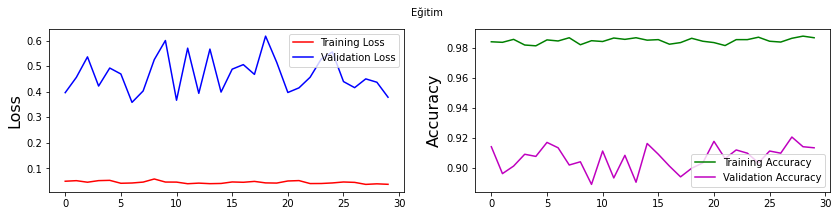

In [23]:
plt.figure(figsize=(14,3))
plt.subplot(1, 2, 1)
plt.suptitle('Eğitim', fontsize=10)
plt.ylabel('Loss', fontsize=16)
plt.plot(hist.history['loss'], color ='r', label='Training Loss')
plt.plot(hist.history['val_loss'], color ='b', label='Validation Loss')
plt.legend(loc='upper right')


plt.subplot(1, 2, 2)
plt.ylabel('Accuracy', fontsize=16)
plt.plot(hist.history['accuracy'], color ='g', label='Training Accuracy')
plt.plot(hist.history['val_accuracy'], color ='m', label='Validation Accuracy')
plt.legend(loc='lower right')

plt.show()

In [24]:
score = model.evaluate(x_test, y_test, verbose=0)
print('Test Loss:', score[0])
print('Test Accuracy:', score[1])

Test Loss: 0.3311389088630676
Test Accuracy: 0.9273039698600769


In [28]:
stop_early = tensorflow.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10)

epochs = 30
batchSize = 32

# run the model

hist = model.fit(x_train, y_train,
                 epochs=epochs,
                 shuffle=True,
                 batch_size=batchSize,
                 validation_data=(x_val, y_val),
                 callbacks=[stop_early], verbose=2)

Epoch 1/30
175/175 - 12s - loss: 0.0379 - accuracy: 0.9855 - val_loss: 0.5374 - val_accuracy: 0.9162 - 12s/epoch - 69ms/step
Epoch 2/30
175/175 - 12s - loss: 0.0475 - accuracy: 0.9846 - val_loss: 0.4024 - val_accuracy: 0.9105 - 12s/epoch - 69ms/step
Epoch 3/30
175/175 - 12s - loss: 0.0352 - accuracy: 0.9893 - val_loss: 0.4406 - val_accuracy: 0.9162 - 12s/epoch - 69ms/step
Epoch 4/30
175/175 - 12s - loss: 0.0372 - accuracy: 0.9868 - val_loss: 0.4784 - val_accuracy: 0.9019 - 12s/epoch - 69ms/step
Epoch 5/30
175/175 - 12s - loss: 0.0509 - accuracy: 0.9828 - val_loss: 0.6227 - val_accuracy: 0.8905 - 12s/epoch - 69ms/step
Epoch 6/30
175/175 - 12s - loss: 0.0403 - accuracy: 0.9864 - val_loss: 0.4364 - val_accuracy: 0.9191 - 12s/epoch - 69ms/step
Epoch 7/30
175/175 - 12s - loss: 0.0373 - accuracy: 0.9868 - val_loss: 0.4263 - val_accuracy: 0.9091 - 12s/epoch - 69ms/step
Epoch 8/30
175/175 - 12s - loss: 0.0330 - accuracy: 0.9878 - val_loss: 0.4802 - val_accuracy: 0.9141 - 12s/epoch - 69ms/step


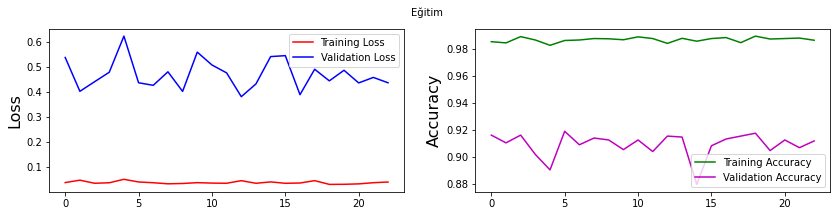

In [29]:
plt.figure(figsize=(14,3))
plt.subplot(1, 2, 1)
plt.suptitle('Eğitim', fontsize=10)
plt.ylabel('Loss', fontsize=16)
plt.plot(hist.history['loss'], color ='r', label='Training Loss')
plt.plot(hist.history['val_loss'], color ='b', label='Validation Loss')
plt.legend(loc='upper right')


plt.subplot(1, 2, 2)
plt.ylabel('Accuracy', fontsize=16)
plt.plot(hist.history['accuracy'], color ='g', label='Training Accuracy')
plt.plot(hist.history['val_accuracy'], color ='m', label='Validation Accuracy')
plt.legend(loc='lower right')

plt.show()

In [30]:
score = model.evaluate(x_test, y_test, verbose=0)
print('Test Loss:', score[0])
print('Test Accuracy:', score[1])

Test Loss: 0.4328095614910126
Test Accuracy: 0.9129937291145325
